In [24]:
import pathlib

from heliostack.image import Image

import torch
import kornia

from astropy.io import fits
from astropy.wcs import WCS
from astropy.time import Time

import pandas as pd


import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from scipy.ndimage import distance_transform_edt, center_of_mass, label, map_coordinates, convolve
import numpy as np

import sep
from sklearn.cluster import DBSCAN

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dtype = torch.float32

def stack(images: list[Image]):
    psi = torch.zeros(2500, 5000, device=device, dtype=dtype)
    phi = torch.zeros(2500, 5000, device=device, dtype=dtype)

    for im in images:
        dx, dy = im.image.shape
        psi[0:dx, 0:dy] += im.image
        phi[0:dx, 0:dy] += im.weight

    s = psi / torch.sqrt(phi)
    return s

### Read in all of the images

In [2]:
EDGE_CUT_PIXELS = 250
def ingest_image(image_path, weight_path, device, dtype) -> Image:
    im = fits.open(image_path)
    wt = fits.open(weight_path)

    wcs = WCS(im[1].header)
    epoch = Time(im[1].header['MJD-OBS'], format='mjd', scale='utc')

    image = Image(im[1].data[EDGE_CUT_PIXELS:-EDGE_CUT_PIXELS, EDGE_CUT_PIXELS:-EDGE_CUT_PIXELS], 
                  wt[1].data[EDGE_CUT_PIXELS:-EDGE_CUT_PIXELS, EDGE_CUT_PIXELS:-EDGE_CUT_PIXELS], 
                  wcs, 
                  epoch, 
                  device=device,
                  dtype=dtype)
    return image

In [3]:
#root = '/nfs/deep/diffim_distant/B1d/20201019/CCD1'
root = '/Users/kjnapier/Desktop/research/data/jts/B1a/20201018/CCD5/'

image_paths = list(pathlib.Path(root).glob('*.diff.rescale.fits.fz'))
weight_paths = list(pathlib.Path(root).glob('*.diff.weight.fits.fz'))
assert len(image_paths) == len(weight_paths)

# read in the images
images = []
for i, w in zip(image_paths, weight_paths):
    images.append(ingest_image(i, w, device, dtype))

In [26]:
def extract(s, threshold=2.0, min_area=3):

    ys, xs = torch.where(s > threshold)
    points = np.array([xs.cpu().numpy(), ys.cpu().numpy()]).T
    clustering = DBSCAN(eps=1, min_samples=min_area, algorithm='ball_tree').fit(points)
    keep = clustering.labels_ > 0
    unique_labels = set(clustering.labels_[keep])
    xs = xs[keep]
    ys = ys[keep]
    points = points[keep]

    x_c = []
    y_c = []
    snr = []
    for k in unique_labels:
        class_member_mask = (clustering.labels_[keep] == k)
        x, y = np.mean(xs[class_member_mask].tolist()), np.mean(ys[class_member_mask].tolist())
        x_c.append(x)
        y_c.append(y)

    return x_c, y_c

In [27]:
%%time
s = stack(images)

CPU times: user 670 ms, sys: 54.6 ms, total: 725 ms
Wall time: 131 ms


In [41]:
%%time
xs, ys = extract(s, threshold=2, min_area=2)

CPU times: user 38.9 ms, sys: 2.37 ms, total: 41.3 ms
Wall time: 9.61 ms


In [42]:
%%time
sep_sources = pd.DataFrame(sep.extract(np.float32(s.cpu().numpy()), 2, minarea=2, filter_type='conv', deblend_cont=1.0, clean=False))

CPU times: user 47.9 ms, sys: 1.45 ms, total: 49.4 ms
Wall time: 49.1 ms


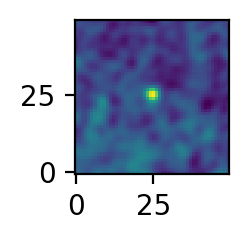

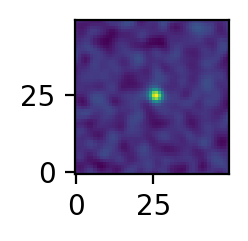

In [39]:
for x, y in zip(xs, ys):
    fig, ax = plt.subplots(figsize=(1, 1))
    x = int(x)
    y = int(y)
    ax.imshow(s[y-25:y+25, x-25:x+25].cpu().numpy(), origin='lower')

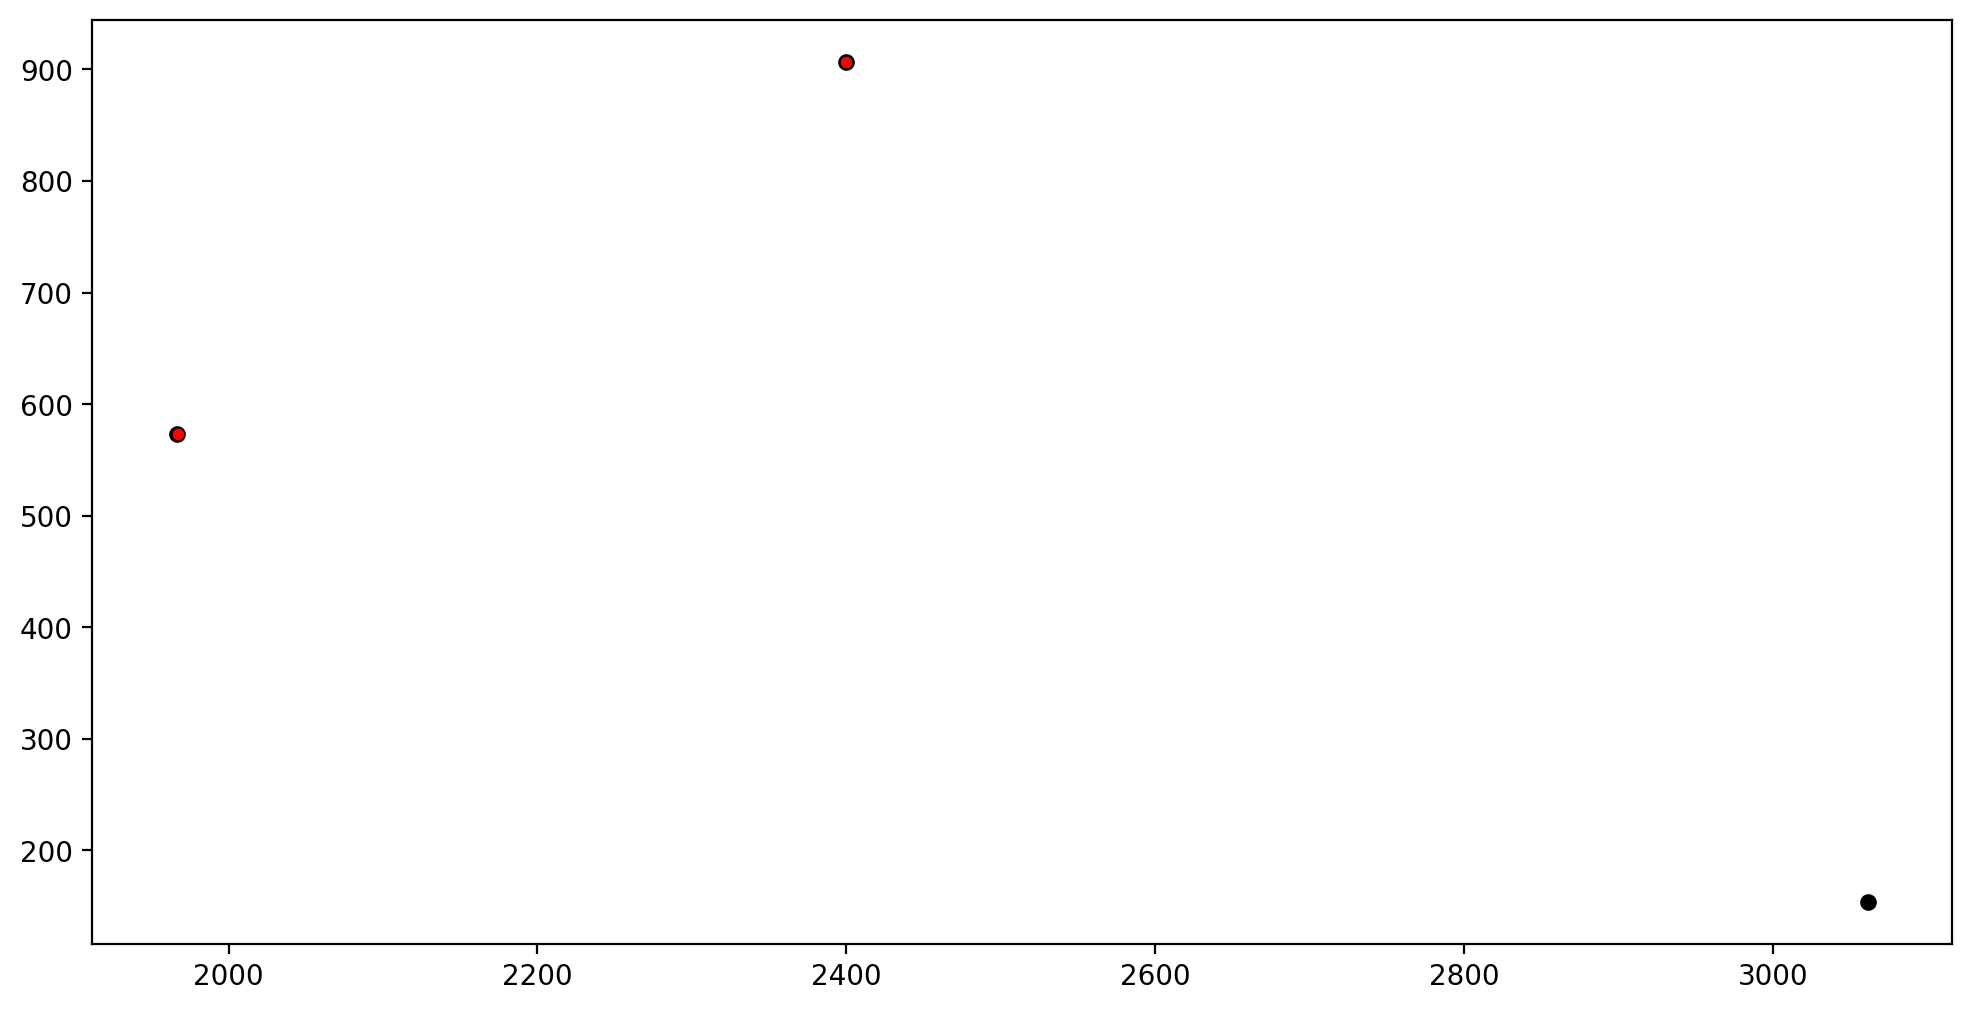

In [40]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.scatter(sep_sources.x, sep_sources.y, s=25, color='black')
ax.scatter(xs, ys, s=10, color='red')

### Calculate the stack rates

In [224]:
# use the grid

CPU times: user 150 ms, sys: 8.94 ms, total: 159 ms
Wall time: 158 ms


### Stack at each rate, and extract sources

In [203]:
%%time
for _ in range(1):
    s = stack(images)
    sources = sep.extract(np.float32(s.cpu().numpy()), 2, minarea=2)

CPU times: user 2.82 s, sys: 46 ms, total: 2.86 s
Wall time: 576 ms


In [206]:
import pandas as pd

In [207]:
pd.DataFrame(sources)

,thresh,npix,tnpix,xmin,xmax,ymin,ymax,x,y,x2,...,cxy,cflux,flux,cpeak,peak,xcpeak,ycpeak,xpeak,ypeak,flag
0,2.0,3,3,557,558,16,17,557.721237,16.706332,0.201054,...,4.677608,9.142162,18.695312,3.908905,12.710938,558,17,558,17,0
1,2.0,7,3,3060,3062,153,155,3061.374202,153.972228,0.378621,...,0.032778,31.370739,39.508301,7.386112,21.687500,3061,154,3061,154,0
2,2.0,4,3,1477,1478,391,393,1477.745599,392.000720,0.189681,...,-0.004755,11.018188,19.075195,3.738708,10.367188,1478,392,1478,392,0
3,2.0,3,2,3542,3543,464,465,3542.761174,464.321604,0.181788,...,-4.549904,9.054855,19.768555,3.980240,13.250000,3543,464,3543,464,0
4,2.0,2,2,1340,1340,523,524,1340.000000,523.505310,0.083333,...,-0.000000,4.051941,10.113281,2.047485,6.175781,1340,524,1340,523,8
5,2.0,4,4,461,462,547,548,461.488802,547.514085,0.249875,...,0.011489,9.093761,18.710938,2.393093,5.656250,461,548,461,548,0
6,2.0,2,2,1400,1401,574,574,1400.469077,574.000000,0.332377,...,-0.000000,4.926517,10.945312,2.615601,6.871094,1400,574,1400,574,8
7,2.0,4,4,1966,1967,573,574,1966.559358,573.493016,0.246477,...,0.027680,17.393009,31.710938,4.947235,12.351562,1967,573,1967,573,0
8,2.0,2,2,1599,1599,662,663,1599.000000,662.497415,0.083333,...,-0.000000,6.153000,15.984375,3.092407,8.023438,1599,662,1599,663,8
9,2.0,8,3,2399,2401,906,908,2399.807997,906.958918,0.470117,...,0.657519,41.651703,48.765762,10.095613,33.656250,2400,907,2400,907,0
